In [1]:
import os

os.chdir("..")

In [2]:
from datasetsforecast.m3 import M3
from utilsforecast.plotting import plot_series
import pandas as pd
from models.NBeatsStackMoe import NBeatsStackMoe
from models.NBeatsMoeLags import NBeatsMoeLags
from neuralforecast import NeuralForecast
from utils import load_dataset, train_test_split
from models.callbacks.probs_collector import GateValuesCollectorCallback
from neuralforecast.losses.numpy import smape
from neuralforecast.models import NBEATS
from neuralforecast.tsdataset import TimeSeriesDataset
import matplotlib.pyplot as plt


# Load the M3 dataset
m3 = M3.load(directory='C:\\Users\\ricar\\mixture_of_experts_time_series\\data\\m3\\', group='Monthly')[0]

# m4['ds'] = pd.to_datetime(m4['ds']).astype(int)

c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-23 22:21:02,268	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-23 22:21:02,482	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
horizon = 18
input_size = 24

In [4]:
def calculate_smape(Y_test_df, Y_hat_df, forecast_col):
    """Calculate the sMAPE."""
    y_true = Y_test_df['y'].values
    try:
        y_hat = Y_hat_df[forecast_col].values
    except Exception as exc:
        y_hat = Y_hat_df
   
    n_series = Y_test_df['unique_id'].nunique()
    try:
        y_true = y_true.reshape(n_series, -1)
        y_hat = y_hat.reshape(n_series, -1)
    except Exception as e:
        raise ValueError("Error reshaping arrays") from e

    return smape(y_true, y_hat)

In [5]:
y_train, y_test = train_test_split(m3, horizon)

prob_collector = GateValuesCollectorCallback(is_stack=True, reset_on_epoch=True)
nf = NeuralForecast(
    models=[
        NBeatsStackMoe(
            input_size=input_size, 
            h=horizon,
            mlp_units = 3 * [[256, 256]],
        ),
        NBEATS(
            input_size=input_size, 
            h=horizon,
            mlp_units = 3 * [[256, 256]],
        ),
    ], 
    freq='M',
)
nf.fit(df=y_train, static_df=None, val_size=horizon)
predictions = nf.predict(futr_df=y_test)

smape_stack= calculate_smape(y_test, predictions, 'NBeatsStackMoe')
print(f'sMAPE for stack: {smape_stack}')
smape_nbeats= calculate_smape(y_test, predictions, 'NBEATS')
print(f'sMAPE for NBEATS: {smape_nbeats}')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 642 K  | train
4 | gate         | Sequential    | 123    | train
-------------------------------------------------------
641 K     Trainable params
1.6 K     Non-trainable params
642 K     Total params
2.571     Total estimated mod

Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 13.66it/s, v_num=92, train_loss_step=509.0, train_loss_epoch=598.0, valid_loss=660.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 13.66it/s, v_num=92, train_loss_step=509.0, train_loss_epoch=598.0, valid_loss=660.0]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 642 K  | train
-------------------------------------------------------
641 K     Trainable params
1.6 K     Non-trainable params
642 K     Total params
2.571     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 16.95it/s, v_num=93, train_loss_step=503.0, train_loss_epoch=593.0, valid_loss=663.0] 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 22:  22%|██▏       | 10/45 [00:00<00:02, 16.95it/s, v_num=93, train_loss_step=503.0, train_loss_epoch=593.0, valid_loss=663.0]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 147.70it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True


INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 174.53it/s]
sMAPE for stack: 0.13844556782715198
sMAPE for NBEATS: 0.13857288754442124


In [15]:
y_hats = []

for i, model in enumerate(nf.models):
    dataset, *_ = TimeSeriesDataset.from_df(df = y_test)
    y_hat = model.decompose(dataset=dataset)

    y_hats.append(y_hat)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 127.54it/s]


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 135.89it/s]


sMAPE for MoEStack: 0.28195253277868876
sMAPE for NBEATS: 0.28131958564051507


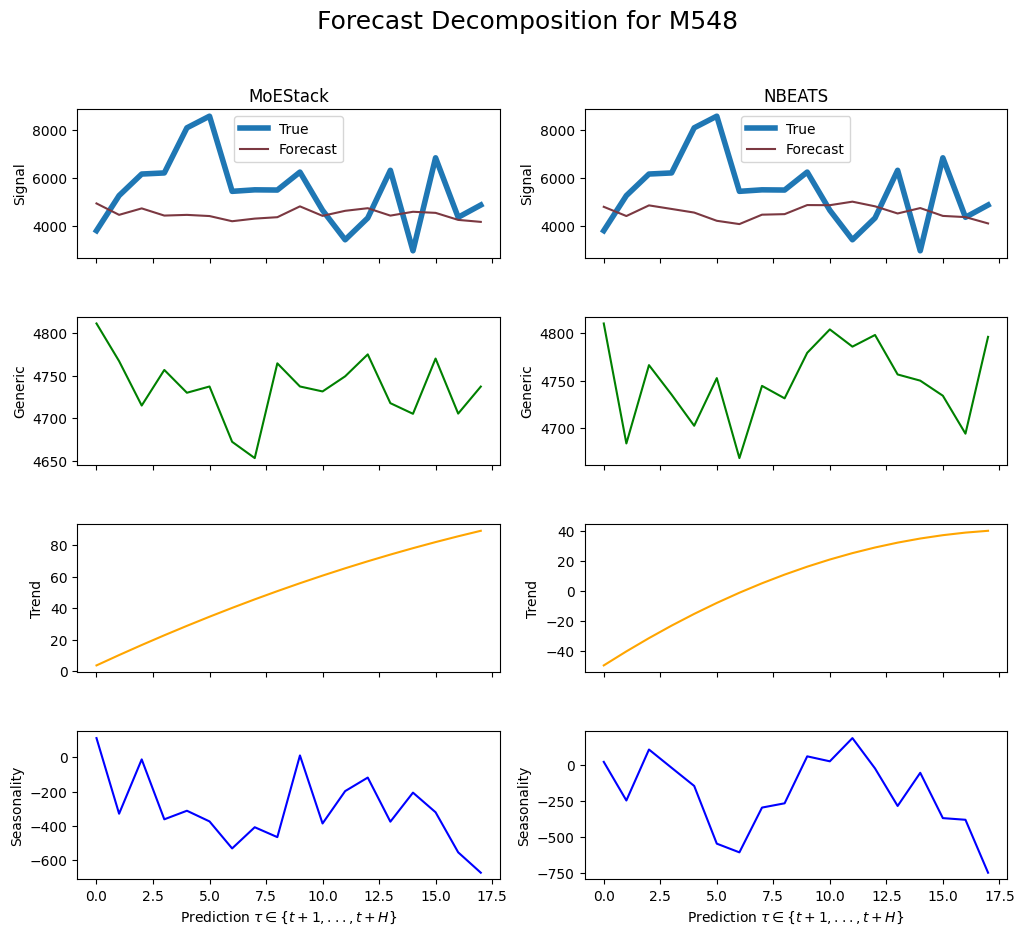

      unique_id         ds        y
16686      M548 1988-07-31  3785.80
16687      M548 1988-08-31  5255.60
16688      M548 1988-09-30  6158.75
16689      M548 1988-10-31  6205.05
16690      M548 1988-11-30  8095.15
16691      M548 1988-12-31  8583.20
16692      M548 1989-01-31  5433.70
16693      M548 1989-02-28  5496.95
16694      M548 1989-03-31  5488.10
16695      M548 1989-04-30  6241.35
16696      M548 1989-05-31  4641.20
16697      M548 1989-06-30  3404.00
16698      M548 1989-07-31  4317.55
16699      M548 1989-08-31  6315.20
16700      M548 1989-09-30  2943.00
16701      M548 1989-10-31  6838.80
16702      M548 1989-11-30  4346.15
16703      M548 1989-12-31  4860.30
sMAPE for MoEStack: 0.48871591073963105
sMAPE for NBEATS: 0.49263297646294224


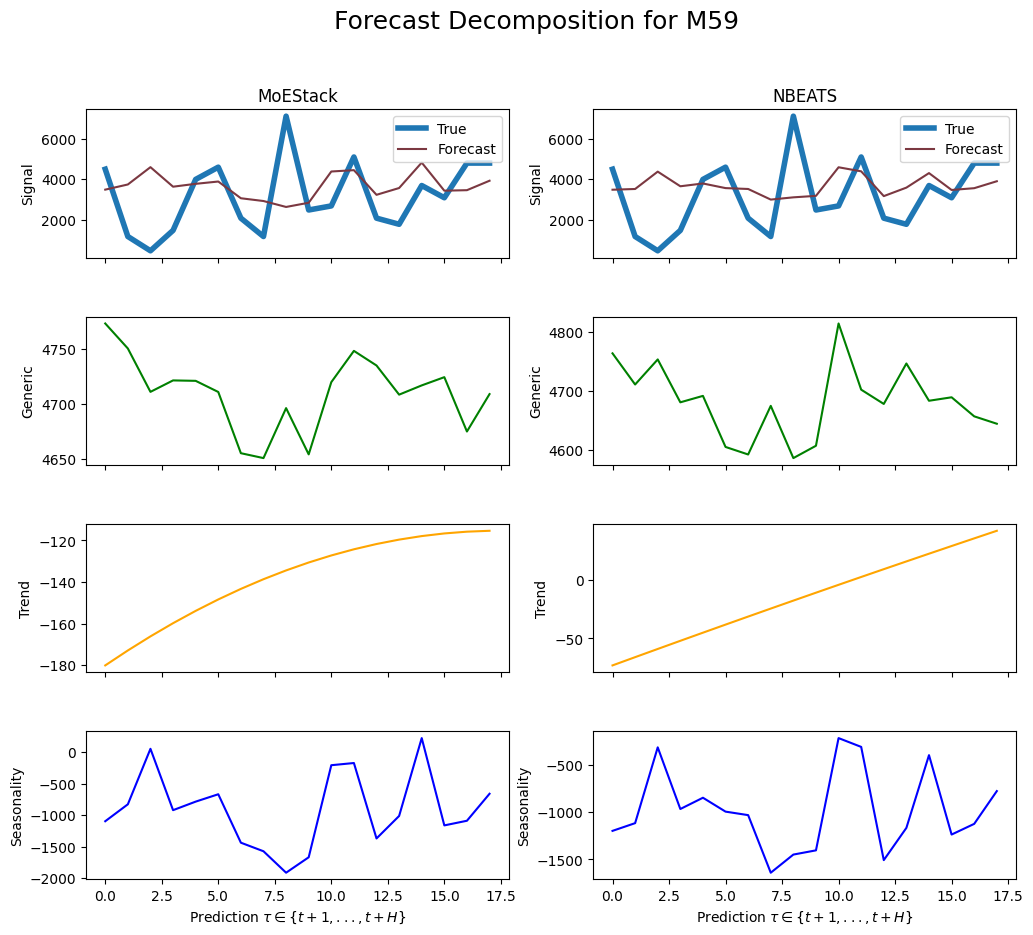

      unique_id         ds       y
17514       M59 1994-04-30  4500.0
17515       M59 1994-05-31  1200.0
17516       M59 1994-06-30   500.0
17517       M59 1994-07-31  1500.0
17518       M59 1994-08-31  4000.0
17519       M59 1994-09-30  4600.0
17520       M59 1994-10-31  2100.0
17521       M59 1994-11-30  1200.0
17522       M59 1994-12-31  7100.0
17523       M59 1995-01-31  2500.0
17524       M59 1995-02-28  2700.0
17525       M59 1995-03-31  5100.0
17526       M59 1995-04-30  2100.0
17527       M59 1995-05-31  1800.0
17528       M59 1995-06-30  3700.0
17529       M59 1995-07-31  3100.0
17530       M59 1995-08-31  4800.0
17531       M59 1995-09-30  4800.0
sMAPE for MoEStack: 0.3492543144485042
sMAPE for NBEATS: 0.3425518232949409


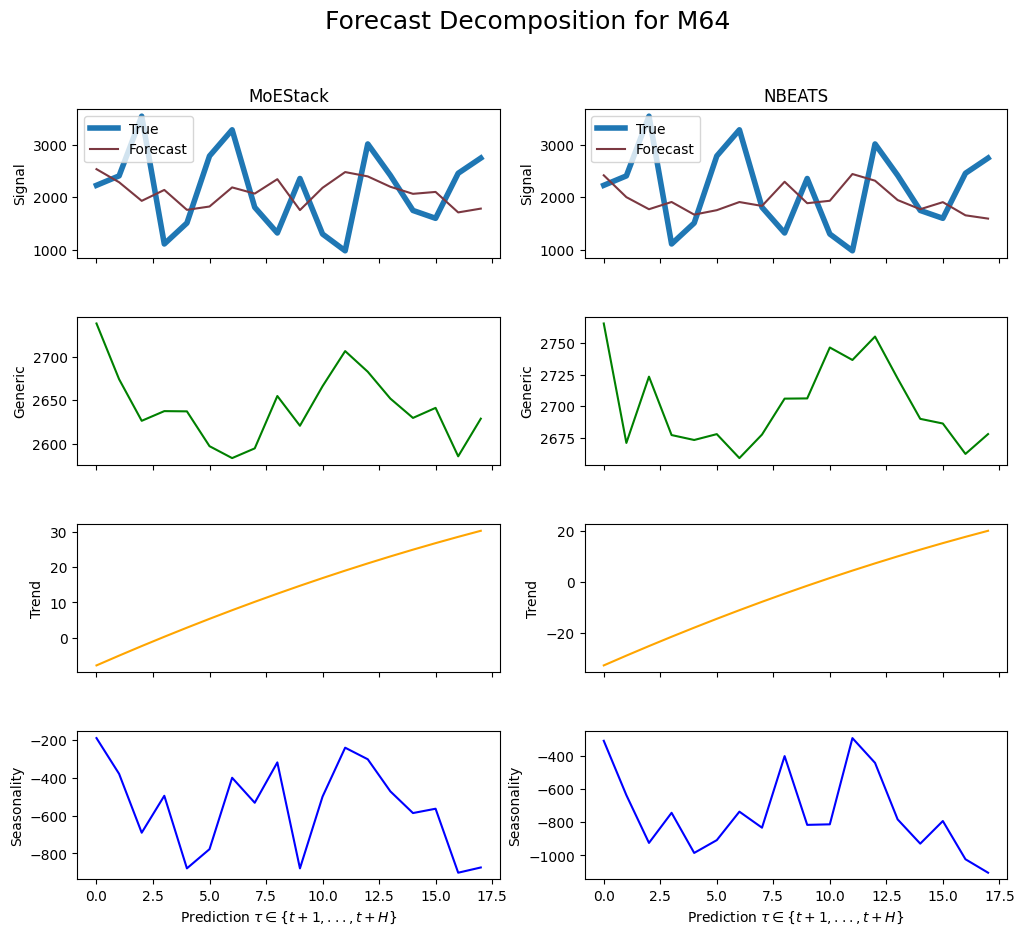

      unique_id         ds       y
18522       M64 1994-04-30  2230.0
18523       M64 1994-05-31  2410.0
18524       M64 1994-06-30  3550.0
18525       M64 1994-07-31  1110.0
18526       M64 1994-08-31  1510.0
18527       M64 1994-09-30  2790.0
18528       M64 1994-10-31  3290.0
18529       M64 1994-11-30  1810.0
18530       M64 1994-12-31  1320.0
18531       M64 1995-01-31  2360.0
18532       M64 1995-02-28  1300.0
18533       M64 1995-03-31   980.0
18534       M64 1995-04-30  3020.0
18535       M64 1995-05-31  2420.0
18536       M64 1995-06-30  1750.0
18537       M64 1995-07-31  1600.0
18538       M64 1995-08-31  2460.0
18539       M64 1995-09-30  2750.0
sMAPE for MoEStack: 0.6651935663858568
sMAPE for NBEATS: 0.6465327567506751


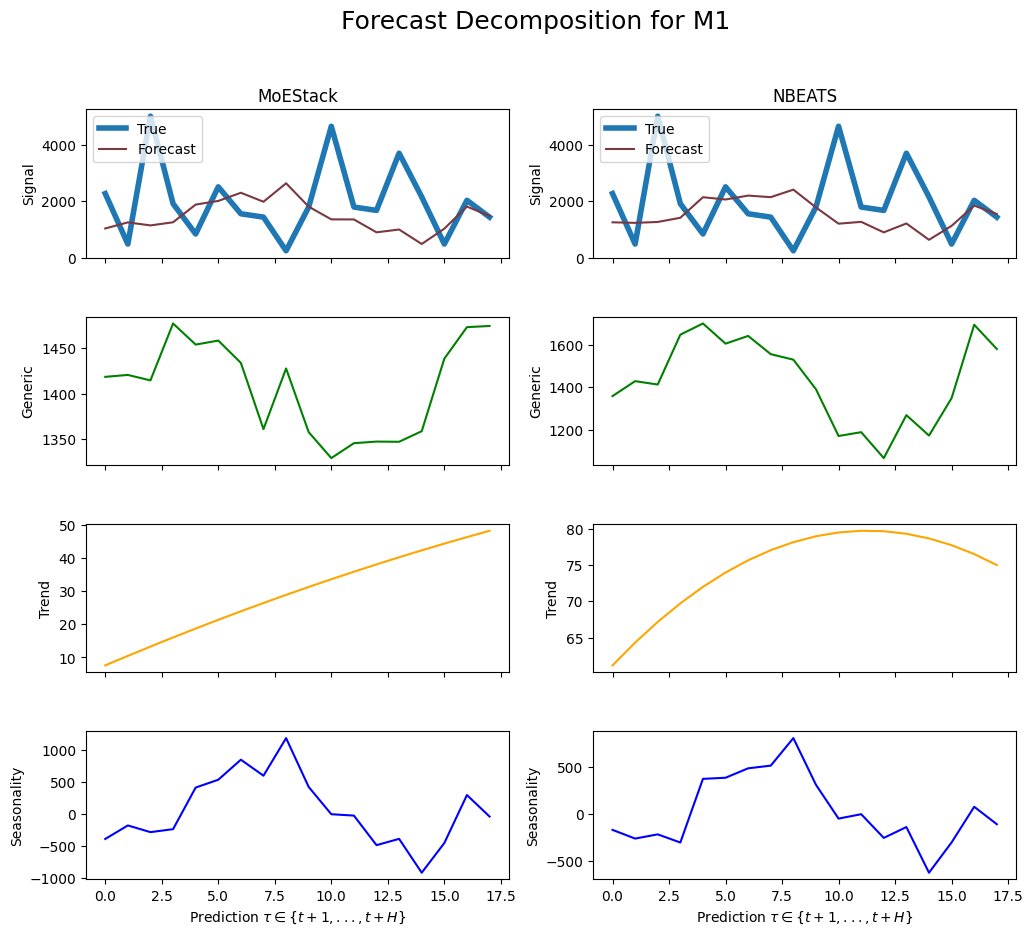

   unique_id         ds       y
0         M1 1994-03-31  2280.0
1         M1 1994-04-30   480.0
2         M1 1994-05-31  5040.0
3         M1 1994-06-30  1920.0
4         M1 1994-07-31   840.0
5         M1 1994-08-31  2520.0
6         M1 1994-09-30  1560.0
7         M1 1994-10-31  1440.0
8         M1 1994-11-30   240.0
9         M1 1994-12-31  1800.0
10        M1 1995-01-31  4680.0
11        M1 1995-02-28  1800.0
12        M1 1995-03-31  1680.0
13        M1 1995-04-30  3720.0
14        M1 1995-05-31  2160.0
15        M1 1995-06-30   480.0
16        M1 1995-07-31  2040.0
17        M1 1995-08-31  1440.0
sMAPE for MoEStack: 0.14574571491649738
sMAPE for NBEATS: 0.12370102252378921


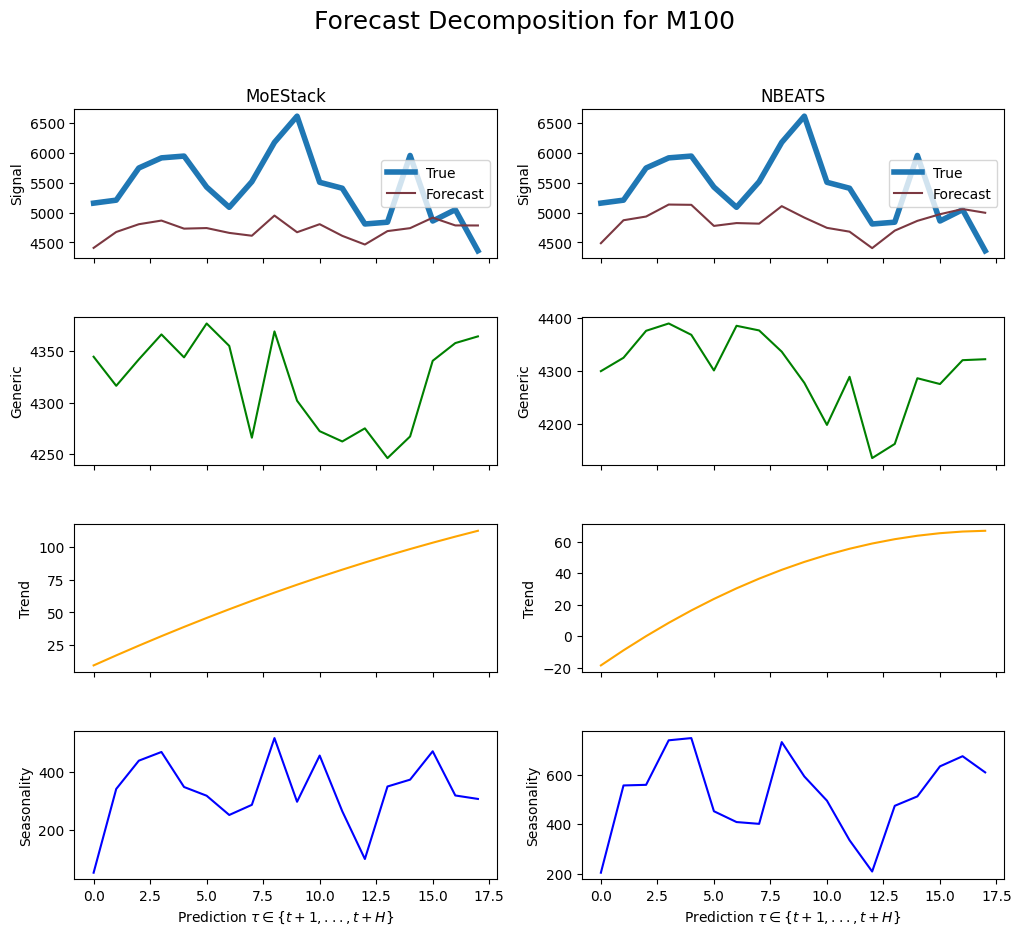

   unique_id         ds       y
36      M100 1994-04-30  5160.0
37      M100 1994-05-31  5210.0
38      M100 1994-06-30  5750.0
39      M100 1994-07-31  5920.0
40      M100 1994-08-31  5950.0
41      M100 1994-09-30  5430.0
42      M100 1994-10-31  5090.0
43      M100 1994-11-30  5520.0
44      M100 1994-12-31  6180.0
45      M100 1995-01-31  6620.0
46      M100 1995-02-28  5510.0
47      M100 1995-03-31  5410.0
48      M100 1995-04-30  4810.0
49      M100 1995-05-31  4840.0
50      M100 1995-06-30  5960.0
51      M100 1995-07-31  4860.0
52      M100 1995-08-31  5050.0
53      M100 1995-09-30  4360.0


In [18]:
to_check_ids = ['M548', 'M59', "M64", "M1", "M100"]
enumerate_models = ['MoEStack', 'NBEATS']
unique_ids = y_test['unique_id'].unique().tolist()

for i, id in enumerate(to_check_ids):

    # select unique_id M1
    m_id = y_test[y_test['unique_id'] == id]
    m_idex = unique_ids.index(id)

    # Shared figure: 4 rows (plot types) x N models (columns)
    fig, ax = plt.subplots(4, len(enumerate_models), figsize=(12, 10), sharex=True)
    fig.suptitle(f'Forecast Decomposition for {id}', fontsize=18)
    fig.subplots_adjust(hspace=0.4)


    for j, model_name in enumerate(enumerate_models):
        y_hat = y_hats[j]  # Get the model-specific predictions

        # Optional: add model title at top
        ax[0, j].set_title(model_name)

        ax[0, j].plot(m_id['y'].values, label='True', linewidth=4)
        ax[0, j].plot(y_hat[m_idex].sum(axis=0).flatten(), label='Forecast', color="#7B3841")
        ax[0, j].legend()
        ax[0, j].set_ylabel('Signal')

        ax[1, j].plot(y_hat[m_idex, 1] + y_hat[m_idex, 0], label='stack1', color="green")
        ax[1, j].set_ylabel('Generic')

        ax[2, j].plot(y_hat[m_idex, 2], label='stack2', color="orange")
        ax[2, j].set_ylabel('Trend')

        ax[3, j].plot(y_hat[m_idex, 3], label='stack3', color="blue")
        ax[3, j].set_ylabel('Seasonality')
        ax[3, j].set_xlabel(r'Prediction $\tau \in \{t+1,..., t+H\}$')

        # Calculate sMAPE
        smape_value = calculate_smape(m_id, y_hat[m_idex].sum(axis=0).flatten(), model_name)
        print(f'sMAPE for {model_name}: {smape_value}')

    plt.show()

    # Debug output
    print(m_id)
